In [1]:
import pandas as pd                                  # smart dataFrame for data manipulations
import numpy as np
import sys
import scipy

import requests                                      # used to read data from URL address
from requests.auth import HTTPBasicAuth              # setup authentication of URL 

import matplotlib.pyplot as plt                      # plotting results in a neat way!
from matplotlib.colors import ListedColormap         # ..used for decision surface plots
import matplotlib as mpl

import seaborn as sn                                 # nice for plotting heatmaps, used for correlation matrix

from sklearn import tree                             # classifier decision trees
from sklearn import neighbors                        # classifier kNN
from sklearn.ensemble import RandomForestClassifier  # classifier Random Forest
from sklearn.neural_network import MLPClassifier     # classifier multi-layer perceptron
from random import uniform as random_uniform         # random number generator for randomizing train/test samples

from IPython.core.display import Image               # ...for displaying images in notebook, used for decision tree pictures
from six import StringIO                             # write string buffers as files, used for making decision tree pictures
import re
import io
import VisualizeNN as VisNN

import seaborn as sns                               # If you don't have seaborn then run the line below
from sklearn import cluster                         # !pip install seaborn


# import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('mode.chained_assignment', None)

mpl.rcParams.update({'font.size': 18, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

In [2]:
# Loading our data in its raw form

urlGam = "https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX" # Make sure the url is the raw version of the file on GitHub
downloadGam = requests.get(urlGam).content
GamRaw = pd.read_csv(io.StringIO(downloadGam.decode('utf-8')))

urlNeut = "https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46" # Make sure the url is the raw version of the file on GitHub
downloadNeut = requests.get(urlNeut).content
NeutRaw = pd.read_csv(io.StringIO(downloadNeut.decode('utf-8')))

In [3]:
# Making the training data sets

GamTrain = GamRaw.sample(frac=0.1)
NeutTrain = NeutRaw.sample(frac=0.1)

# Add a distriction column to the data, to know which is gam and which is neut for later graphing

GamTrain["distinction"] = 1
NeutTrain["distinction"] = 0

In [4]:
# Combining Neut and Gam dataframes to a single frame for plotting

plotFrame = pd.concat([GamTrain, NeutTrain], ignore_index=True, axis=0)

print(plotFrame.shape)
plotFrame.head(-1)

(8687, 12)


,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
0,96.58680,-70.5308,1.265200,11,1,0.986081,0.803499,0.969992,0.986098,0.002437,0.149947,1
1,125.71000,-25.2972,3.201640,22,1,1.977750,0.650147,0.955343,0.975841,0.002329,0.250814,1
2,29.96720,104.5800,1.254860,19,1,0.740488,0.639192,0.942708,0.953890,0.002857,0.937736,1
3,29.35430,-78.5415,1.428750,6,1,1.212500,0.848641,1.000000,0.991585,0.001558,0.049889,1
4,96.60220,-114.7440,3.014480,18,1,2.182820,0.751314,0.974491,0.979027,0.002527,0.238299,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8681,50.06550,-159.4260,0.627275,22,1,0.245574,0.621314,0.807478,0.387760,0.182990,0.996687,0
8682,27.92890,-128.6140,0.493674,6,1,0.228545,0.471259,0.982363,0.974841,0.002583,0.212763,0
8683,70.51130,-16.3840,0.270176,17,1,0.093024,0.583568,0.892734,0.424312,0.168316,0.995112,0
8684,1.56449,-143.3600,3.241100,25,2,1.114930,0.713856,0.570350,0.690954,0.017151,0.918022,0


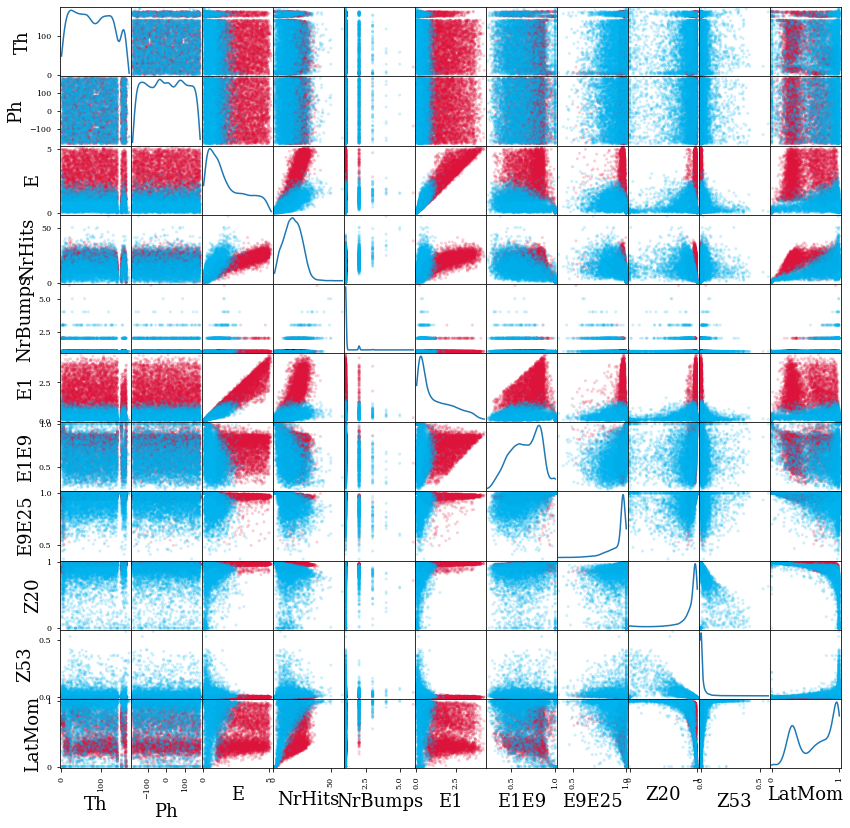

In [5]:
colors = ['#DC143C', '#00B2EE']        #RED colour('#DC143C')  = Gamma Rays (photons)
                                       #BLUE colour('#00B2EE') = Neutrons

_ = pd.plotting.scatter_matrix(plotFrame[['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom']], 
                               figsize=(14,14), 
                               diagonal='kde', 
                               alpha=0.2, 
                               color=[colors[x-1] for x in list(plotFrame.distinction)])

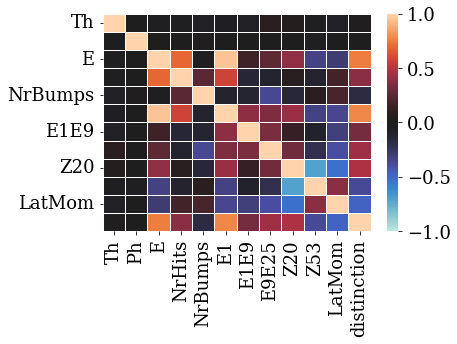

<Figure size 36000x36000 with 0 Axes>

In [6]:
# Heatmap for data correlations

sns.heatmap(plotFrame.corr(), 
            annot=False,
            linewidths=0.5,
            vmin=-1,
            vmax=1,
            center=0,
            cbar=True)

plt.figure(figsize=(500, 500))
plt.show()

In [7]:
## Data normalisation function

def NormalizeData(data, feature_list):
    """
    Normalize features in "feature_list" of dataFrame "data".
    New features will be added as columns to the dataFrame with label "_normal".
    The function returns the updated table.
    """
    
    # Dont modify the original dataFrame "data"
    data_tmp = data.copy()

    # Run over all features and create new column with "_normal"
    for feature in feature_list:
        feature_new = feature + "_normal"
        data_tmp[feature_new] = (data_tmp[feature] - data_tmp[feature].mean()) / data_tmp[feature].std()

    # Return the updated dataFrame
    return data_tmp


In [8]:
# We now normalise the features that could be correleated later

plotFrame = NormalizeData(plotFrame, ["E", "NrHits", "E1", "LatMom"])

# Check that the average = 0 and std = 1 for the normalized numbers:
plotFrame[["E_normal", "NrHits_normal", "E1_normal", "LatMom_normal"]].describe()

,E_normal,NrHits_normal,E1_normal,LatMom_normal
count,8.687000e+03,8.687000e+03,8.687000e+03,8.687000e+03
mean,6.281892e-16,2.945011e-15,-1.875749e-15,-1.812263e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.289831e+00,-2.090810e+00,-1.099358e+00,-2.148857e+00
25%,-8.398264e-01,-7.680755e-01,-8.187567e-01,-9.905059e-01
50%,-3.221268e-01,2.556546e-02,-3.937479e-01,1.837357e-01
75%,7.552136e-01,6.869329e-01,6.878178e-01,9.856074e-01
max,2.388889e+00,5.713326e+00,3.057221e+00,1.247607e+00


In [9]:
#
# The engine code behind the ML algorithm used in this example.
# We make use of classifier "classifier":
#

def Classify(classifier, data, params,
             prop_test=0.5, feature_list=['E_normal','NrHits_normal'], 
             plot_ds=False, plot_tree=False, plot_network=False):
    """
    Use "classifier" algorithm to classify dataset data. Use feature list feature_list
    and use prop_test fraction of the data as test sample, rest for training.
    The function returns an updated dataset including a column with predicted class.
    """
    
    assert 0<prop_test<1
     
    #
    # make a copy of the dataframe. The original table will not be altered.
    #
    data_tmp = data.copy()
    #
    # Add a column specifying whether event is used for training or for testing
    #
    data_tmp['is_train'] = np.random.uniform(0, 1, len(data_tmp)) <= (1-prop_test)
    #
    # Extract two seperate datasets for training (train) and testing (test)
    #
    train, test = data_tmp[data_tmp['is_train']==True], data_tmp[data_tmp['is_train']==False]
    
    
    if   (classifier=="DT"):
        # we create an instance of Decision Tree Classifier.
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          min_impurity_decrease=params[0],
                                          max_depth=params[1])
    elif (classifier=="RF"):
        # we create an instance of Random Forest Classifier.
        clf = RandomForestClassifier(n_estimators=params[0], 
                                     max_features=params[1])
    elif (classifier=="kNN"):
        # we create an instance of kNN Classifier.
        clf = neighbors.KNeighborsClassifier(n_neighbors=params[0])
    elif (classifier=="MLP"):
        # we create an instance of MLP Classifier.
        clf = MLPClassifier(solver='lbfgs', activation='logistic', #solver=quasi-Newton, activation=sigmoid
                            max_iter=5000, 
                            hidden_layer_sizes=params[0])
    else:
        print(" Classifier not implemented: ", classifier)
        return None
    
    # Fit the data with the selected classifier...
    clf.fit(train[feature_list],train['distinction'])
    
    #evaluate the training points
    trainpred = clf.predict(train[feature_list]) # majority vote result
    train['prediction'] = [x for x in trainpred]
   
    # Predict on the testing points       
    testpred = clf.predict(test[feature_list])   # majority vote result
    test['prediction'] = [x for x in testpred]
 
    data_update = train.append(test)
     
    # Make it possible to plot the decision surface if plot_ds flag set to True and nr of features equals 2.
    if (plot_ds) & (len(feature_list)==2):
        PlotDecisionSurface(clf,data_update,feature_list)

    # In the case the classifier is a decision tree, allow for the possibility to plot the tree, 
    # only when plot_tree is set to True.
    if (plot_tree) & (classifier=="DT"): 
        PlotTree(clf, feature_list)
  
    # Plot the network structure in case of multi-layer perceptron
    # Only when plot_network flag is set to True. Comment out if VisNN code not available!
    #if (plot_network) & (classifier=="MLP"):   
        #network_structure = np.hstack(([len(feature_list)], np.asarray(clf.hidden_layer_sizes), [data['distinction'].nunique()]))
        # Draw the Neural Network with weights given by clf.coefs_
        #network=VisNN.DrawNN(network_structure, clf.coefs_)
        #network.draw()
            
    # Return the updated version of the dataFrame including labels "is_train" and "predicted".
    return data_update


In [20]:
#Function of Merit

def FOM(data):
    """
    A function which takes the total amount of trained and test data outputed
    by the classifier function and returns a number based on the Function of
    Merit formula introduced in 'Assignment4.pdf'. The FOM function drops the 
    trained data and measures how many of the tested data were 'predicted' to
    be a photon (S) and compares it to how many were 'predicted' to be a photon
    but are actually a neutron (B).
    """
    #Droping all features except for 'distinction' and 'prediction'
    data_FOM = data.loc[data['is_train'] == False]  #diselecting the training data
    data_FOM = data.drop(columns=['Th', 'Ph','NrHits','NrBumps','E','E1','E1E9','E9E25','Z20','Z53','LatMom','E_normal','NrHits_normal','E1_normal','E1_normal', 'LatMom_normal'])

    #Selecting the rows where 'prediction'=1 ie Gam and measring length  
    S = len(data_FOM.loc[data_FOM['prediction'] == 1])

    #Selecting the rows for when 'prediction' =! 'distinction' and measuring length
    B = len(data_FOM.loc[(data_FOM['distinction'] == 0) & (data_FOM['prediction'] == 1)])

    #Compute FOM
    FOM = S / np.sqrt(S + B)
    
    return FOM

In [21]:
#Graphing and Visualisation functions


# PlotTree: a procedure that displays the tree structure of classifier clf...

def PlotTree(clf, feature_list):
    """
    Plot the decision tree of classifier "clf" with list of features given in "feature_list".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(feature_list):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return 


from matplotlib.colors import ListedColormap


# PlotDecisionSurface: function that creates decision surface based on classifier clf
# and features in feature_list of dataFrame data. It uses "meshgrid" of numpy to generate
# grid of points to evaluate by classifier. For plotting, it uses "pcolormesh" of matplotlib.


def PlotDecisionSurface(clf, data, feature_list, label='distinction', step=0.01):
    """
    Function that creates a decision surface of classifier "clf"
    together with features from the two entries of the "features_list" of "data"
    """
    X = data[feature_list[0]].values
    Y = data[feature_list[1]].values
    
    # colors associated with the two classes, light is used for surface and bold for datapoints
    cmap_light = ListedColormap(['#87CEFA', '#F08080'])
    cmap_bold  = ListedColormap(['#00B2EE', '#DC143C'])
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max] x [y_min, y_max].
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Plot the data points
    plt.scatter(X, Y, s=40, c=data[label], cmap=cmap_bold,alpha=0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.show()
    return

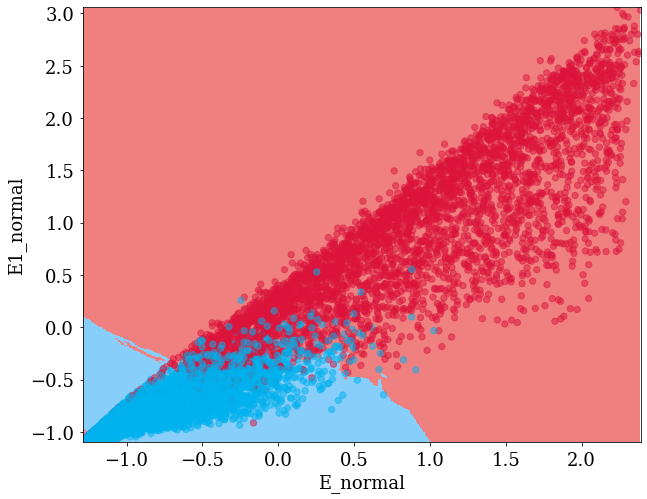

FOM =  63.336300010861436


In [12]:
#
# Let's test Classify function for a kNN test, and see what it creates
#
classifier            = 'kNN'
min_impurity_decrease = 0.3
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal'] 
plot_ds               = True
plot_tree             = True
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=[9], prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

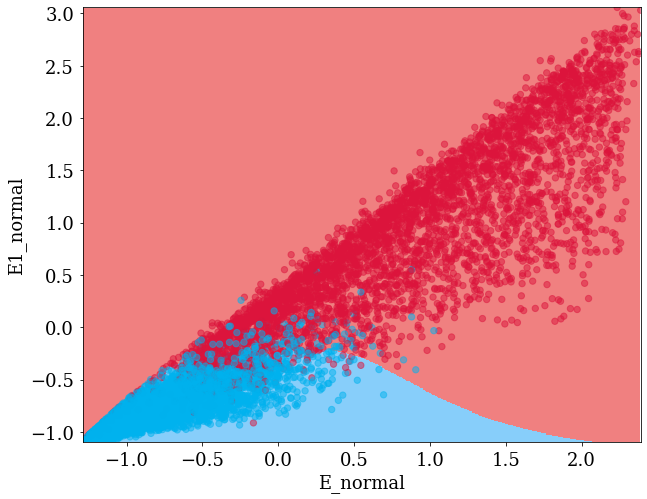

FOM =  63.35345200587967


In [33]:
#
# Let's test Classify function for a multi-layer perceptron, and see what it creates
#
classifier            = 'MLP'
hidden_layers         = (8)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

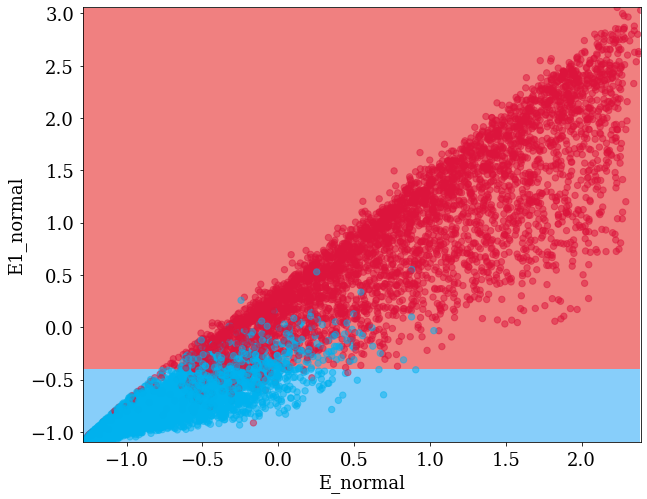

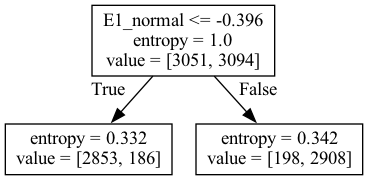

FOM =  63.96367212216128


In [34]:
#
# Let's test Classify function for a decision tree, and see what it creates
#
classifier            = 'DT'
min_impurity_decrease = 0.3
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.3
feature_list          = ['E_normal', 'E1_normal'] 
plot_ds               = True
plot_tree             = True
plot_network          = True

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

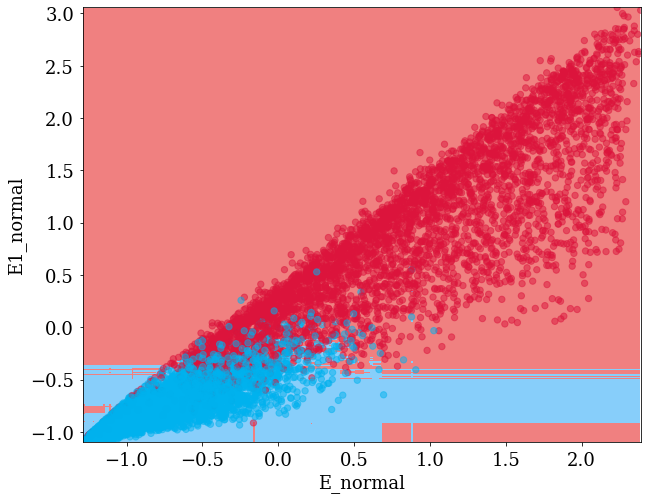

FOM =  64.46270218285044


In [42]:
#
# Let's test Classify function for a Random Forrest, and see what it creates
#
classifier            = 'RF'
n_estimators          = 15
max_features          = 'auto'
params                = [n_estimators,max_features]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

In [15]:
#
# Piece of code that performs cross validation and returns for each validation the success rates
#
def ClassifierTest(classifier, data, params, 
                    reps=1, prop_test=0.3, 
                    feature_list=['E_normal', 'E1E9_normal'], 
                    plot_ds=False,
                    plot_tree=False):
    """ 
    Function that performs a classification for classifier "classifier" for "reps" cross validations. 
    It returns the error rate for train and test samples.
    """
    
    assert 0<prop_test<1
      
    train_result = []
    test_result  = []
        
    for rep in range(reps):
      
        dn = Classify(classifier=classifier, data=data, params=params,
                      prop_test=prop_test, feature_list=feature_list, 
                      plot_ds=plot_ds, plot_tree=plot_tree)
        
        success_train, success_test = GetNrOfSuccesses(dn)
        
        train_result.append(success_train)
        test_result.append(success_test)
        
    return [train_result, test_result]

In [16]:
def getClusters(k, frame, variables):
    '''
    Plots two parameters from a dataframe with cluster centers.
    
    Parameters:
    k (int)                  -- Number of clusters
    frame (pandas dataframe) -- The dataframe to examine
    variables (numpy array)  -- Columns to examine
    '''
    
    start = np.random.rand(k, 2)
    kmeans = cluster.KMeans(n_clusters=k, max_iter=1000, init=start, n_init=1)
    kmeans.fit(frame[variables])
    
    labels    = kmeans.labels_
    centroids = kmeans.cluster_centers_
    nriter    = kmeans.n_iter_
    
    centroids = centroids.reshape(k, 2)
    centroidFrame = pd.DataFrame(centroids, columns =['x', 'y'])
    
    fig, axes = plt.subplots(nrows=1, ncols=1,
                            figsize=(8, 8),
                            layout="constrained"
                            )

    sns.scatterplot(data=frame, x=variables[0], y=variables[1], marker='.', hue='distinction', ax=axes).set_title(f'{variables[0]} v.s. {variables[1]}')
    sns.scatterplot(data=centroidFrame, x='x', y='y', marker='X', color='black', s=200, ax=axes)
    plt.show()


# Choosing a classifier and features

Picking which features are the most powerful ones from the visualisation matrix. As it can be seen the features where the data points are most clearly distinquished are 'E','E1', 'LatMom' and 'NrHits'. From the tests that are run earlier the 'MLP' classifier and the kNN classifier have the highest FOM. Since they tend to be more or less equal we have chosen the 'MLP' classifier to run the data for the rest of the Assignment.

In [17]:
FOM_list = []
layer_num = range(1,31)

for i in layer_num:

    classifier            = 'MLP'
    hidden_layers         = i
    params                = [hidden_layers]
    prop_test             = 0.3
    feature_list          = ['E_normal', 'E1_normal']
    plot_ds               = False
    plot_tree             = False
    plot_network          = False



    data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


    #print(f'FOM = {FOM(data_new)} for i={i}')
    FOM_list.append(FOM(data_new))

print(FOM_list)


[63.31157122579031, 63.34239422602729, 63.47929185347769, 63.417712173977385, 63.4714301790939, 63.39750959562252, 63.57098759835061, 63.469681714583466, 63.63773080940293, 63.48781943835133, 63.47616345767603, 63.426254783948636, 63.42423981558854, 63.5018112819858, 63.36780863663394, 63.360597506182536, 63.36714727785569, 63.45771615744173, 63.3651811341184, 63.398641257605675, 63.21470550236462, 63.32842042228278, 63.54458724663592, 63.493687883111335, 63.63882129634004, 63.27390309349799, 63.65821161194353, 63.47547844354041, 63.588122099307675, 63.41438242317234]


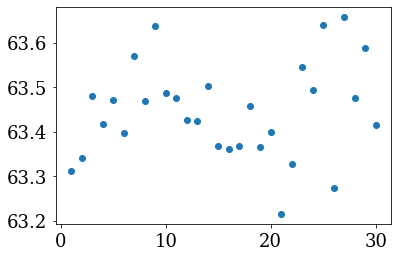

In [18]:
plt.scatter(layer_num,FOM_list)
plt.show()

We conclude from the graph above that the best amount of hidden layers is 21-25 since it gives highest chance that we get a larger FOM. It can also be seen that as we increase the amount of hidden layers FOM also increases. A maximum amount of hidden layers had to be chosen as it can be very computationally expensive to run the MLP classifier with hidden layers larger than 30.

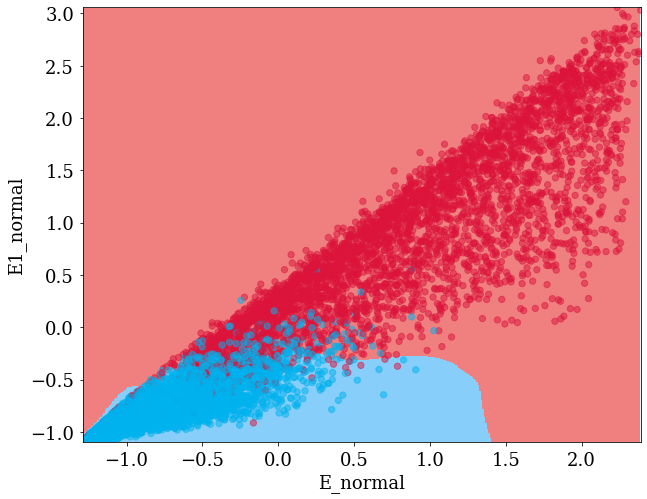

FOM =  63.42761287653212


In [19]:
#Dividing the training and learning data having 50% each and using the 
#the amount of hidden layers that maximises FOM.

classifier            = 'MLP'
hidden_layers         = (24)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

From the graph above it can be seen that there is a small amount of overfitting in the begining of the graph.

In [ ]:
def FOM_checker(data):
    feature_list = [['E_normal', 'E1_normal'],['E_normal','NrHits'],['E_normal','LatMom_normal'],
                    ['E1_normal','NrHits'],['E1_normal','LatMom'],['']
                    ['E_normal', 'E1_normal', 'NrHits_normal','LatMom'], ['E_normal', 'LatMom_normal', 'E1_normal']]
    for i in feature_list:
        FOM(data)
        print('FOM = ', FOM(data_new))
